# Recommendation system for restaurants
### Based on the [Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset).  

## 0. Libraries
First of all, we define all the libraries we need.

In [1]:
import numpy as np
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt 
import joblib as jl
import pickle
import glob
import os

## 1. Data cleaning
### Based on [Ashish Gandhe's kernel](https://www.kaggle.com/wenqihou828/recommendation-for-yelp-users-itself).

We execute the code in ```recommendation_system_preprocessing.ipynb``` in order to
clean the data and to reduce the size of the dataset, using pickles instead of json and dropping unnecessary columns.

We explore the resulting datasets: 

In [5]:
dataset_list = glob.glob("../dataset/[!checked]*.pickle")
for d in dataset_list:
    pickle_dataset = open(d, "rb")
    dataset = pickle.load(pickle_dataset)
    
    f = os.path.splitext(os.path.basename(d))[0]
    c = ", ".join(list(dataset.columns))
    s = dataset.shape
    
    print("Dataset '" + f + "':")
    print("\tfeatures:", c)
    print("\tshape:", s)
    print()
    
    del dataset

Dataset 'all_checkin':
	features: business_id, date
	shape: (57402, 2)

Dataset 'all_review':
	features: review_id, user_id, business_id, stars, useful, funny, cool, text, date
	shape: (4201684, 9)

Dataset 'all_tips':
	features: restaurant_name, tips_date, user_id
	shape: (770878, 3)

Dataset 'all_users':
	features: user_id, user_name, average_stars, yelping_since, review, years_of_elite, fans, useful, cool, funny, friends
	shape: (1148098, 11)

Dataset 'restaurants':
	features: name, business_id, address, cuisine, postal_code, latitude, longitude, review_count, stars, OutdoorSeating, BusinessAcceptsCreditCards, RestaurantsDelivery, RestaurantsReservations, WiFi, Alcohol, categories, city, Monday_Open, Tuesday_Open, Wednesday_Open, Thursday_Open, Friday_Open, Saturday_Open, Sunday_Open, Monday_Close, Tuesday_Close, Wednesday_Close, Thursday_Close, Friday_Close, Saturday_Close, Sunday_Close
	shape: (59371, 31)



## 2. Fake Review Detection
### Based on Zhiwei Zhang's [work](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781) and [code](https://github.com/zzhang83/Yelp_Sentiment_Analysis).

Then, in order to filter out deceptive reviews, that could alter the results
of our analysis, we load the model based on Support Vector Machine
defined in ```Yelp_sentiment_analysis/Scripts/fake_reviews.ipynb```
by [Zhiwei Zhang](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781),
that has the best scores for accuracy, precision, recall and f1-score.

In [2]:
vectorizer = jl.load('../models/tfidf_vectorizer.joblib')
svc = jl.load('../models/fake_review_svc_model.joblib')

Now, we can apply this model to our data.

In [4]:
pickle_review = open("../dataset/all_review.pickle","rb")
review = pickle.load(pickle_review)

review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,I'll be the first to admit that I was not exci...,2013-01-20 13:25:59
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,Tracy dessert had a big name in Hong Kong and ...,2016-05-07 01:21:02
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,This place has gone down hill. Clearly they h...,2010-10-05 19:12:35
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,"Like walking back in time, every Saturday morn...",2011-11-30 02:11:15


In [5]:
texts = list(review["text"])
X = vectorizer.transform(texts)
predictions = svc.predict(X)

In [6]:
print(type(predictions))
print("SVC predictions:", predictions)

<class 'numpy.ndarray'>
SVC predictions: [1 1 1 ... 1 1 1]


Now we repeat the whole process with a different model that allows us to
obtain real weights instead of a binary evaluation. 

In [7]:
cal_svc = jl.load('../models/fake_review_cal_svc_model.joblib')
cal_predictions = cal_svc.predict_proba(X)


In [8]:
print("Calibrated SVC predictions:\n", cal_predictions)
cal_predictions = np.array([x[1] for x in cal_predictions])
print("Calibrated SVC predictions for class '1':\n", cal_predictions)

Calibrated SVC predictions:
 [[0.12112422 0.87887578]
 [0.011      0.989     ]
 [0.03538102 0.96461898]
 ...
 [0.36147536 0.63852464]
 [0.00379598 0.99620402]
 [0.00133685 0.99866315]]
Calibrated SVC predictions for class '1':
 [0.87887578 0.989      0.96461898 ... 0.63852464 0.99620402 0.99866315]


In [9]:
print("columns before:\n", review.columns)
checked_review = review.assign(bin_truth_score=predictions, real_truth_score=cal_predictions)
print("columns after:\n", checked_review.columns)

columns before:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
columns after:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


Let's see what we just obtained.

In [10]:
checked_review[['review_id', 'text', 'bin_truth_score', 'real_truth_score']].head()

,review_id,text,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill. Clearly they h...,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...",1,0.975404


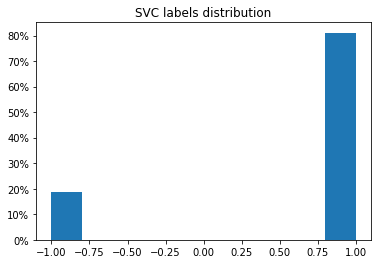

In [11]:
data = checked_review['bin_truth_score']
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.title("SVC labels distribution")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

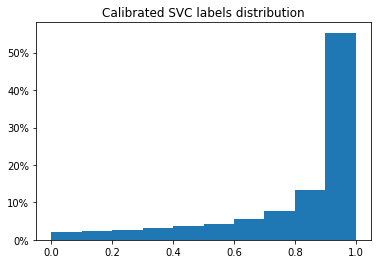

In [12]:
data = checked_review['real_truth_score']
plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.title("Calibrated SVC labels distribution")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Finally, we can save the new dataset without the ```text``` column,
in order to save space and computation time.  

In [17]:
checked_review.drop(columns=['text'], inplace=True)
checked_review.to_pickle('../dataset/checked_review.pickle')

Check that everything has worked properly. 

In [18]:
pickle_review = open('../dataset/checked_review.pickle',"rb")
final_review = pickle.load(pickle_review)
print(final_review.columns)
final_review.head()

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,2018-01-09 20:56:38,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404


## 3. Historical features

Following [this paper](https://www.semanticscholar.org/paper/Restaurant-Recommendation-System-Gandhe/093cecc3e53f2ba4c0c466ad3d8294ba64962050),
we add some historical features to our dataset:
1. user-level features:
    <br>1.1. average of the ratings given by a certain user,
    <br>1.2. number of reviews written by a certain user,
2. business-level features:
    <br>2.1. average of the ratings given to a certain restaurant,
    <br>2.2. number of reviews written about a certain restaurant,
3. user-business features:
    <br>3.1. average rating given by a certain user to each category,
    <br>3.2. average of the ratings given by a certain user to the categories of a certain restaurant.

Before proceeding with the computation of the new features, we have to split the dataset in three parts:
1. <i>Test set</i>, from the last day considered in the dataset, to the previous `M` months;
2. <i>Training set</i>, from the day before the beginning of the test set, up to `N` months before;
3. <i>History</i>, the remaining part of the dataset, used to compute historical features.

For the moment, we pick `m=2` and `n=9`, so the test set goes from 10/1/2018 to 11/30/2018,
the training set goes from 1/1/2018 to 9/30/2018, the history contains the remaining data,
from 10/12/2004 to 12/31/2017.

In [7]:
pickle_review_all = open("../dataset/checked_review.pickle", "rb")
review_all = pickle.load(pickle_review_all)
review_test = review_all[review_all['date']>=np.datetime64('2018-10-01')]
review_train = review_all[(review_all['date']>=np.datetime64('2018-01-01')) & (review_all['date']<np.datetime64('2018-10-01'))]
review_hist = review_all[review_all['date']<np.datetime64('2018-01-01')]

review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
review_hist.to_pickle('../dataset/m2_n9/review_hist.pickle')

In [9]:
pickle_tips_all = open("../dataset/all_tips.pickle", "rb")
tips_all = pickle.load(pickle_tips_all)
tips_test = tips_all[tips_all['tips_date']>=np.datetime64('2018-10-01')]
tips_train = tips_all[(tips_all['tips_date']>=np.datetime64('2018-01-01')) & (tips_all['tips_date']<np.datetime64('2018-10-01'))]
tips_hist = tips_all[tips_all['tips_date']<np.datetime64('2018-01-01')]

tips_test.to_pickle('../dataset/m2_n9/tips_test.pickle')
tips_train.to_pickle('../dataset/m2_n9/tips_train.pickle')
tips_hist.to_pickle('../dataset/m2_n9/tips_hist.pickle')

In [11]:
# ...
